# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2)

In [1]:
# Load pickled data
import pickle

# Done: fill this in based on where you saved the training and testing data
training_file = "dataset/train.p"
testing_file = "dataset/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

print("Pickle files loaded succesfully")

Pickle files loaded succesfully


In [2]:
### To start off let's do a basic data summary.

# Done: number of training examples
n_train = len(X_train)

# Done: number of testing examples
n_test = len(X_test)

# Done: what's the shape of an image?
image_shape = train['sizes'][0]

# Done: how many classes are in the dataset
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = [29 30]
Number of classes = 43


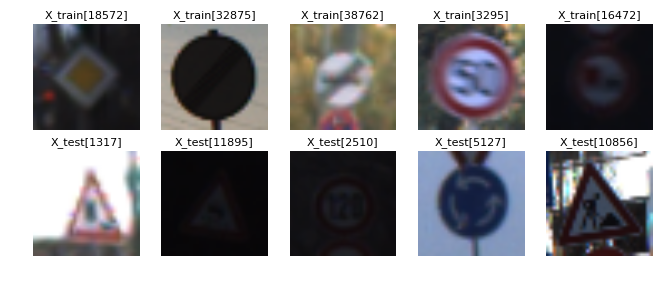

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

# First, some random signs:

import random
from matplotlib import pyplot as plt
%matplotlib inline

fig, axarr = plt.subplots(2,5, figsize=(8, 3))
for i in range(5):
    r1 = random.randint(0, len(X_train))
    r2 = random.randint(0, len(X_test))
    img_tr = X_train[r1]
    img_ts = X_test[r2]
    axarr[0, i].imshow(img_tr)
    axarr[0, i].axis("off")
    axarr[0, i].set_title("X_train[%d]" % r1, fontsize=8)
    axarr[1, i].imshow(img_ts)
    axarr[1, i].axis("off")
    axarr[1, i].set_title("X_test[%d]" % r2, fontsize=8)

(0.0, 1.0, 0.0, 1.0)

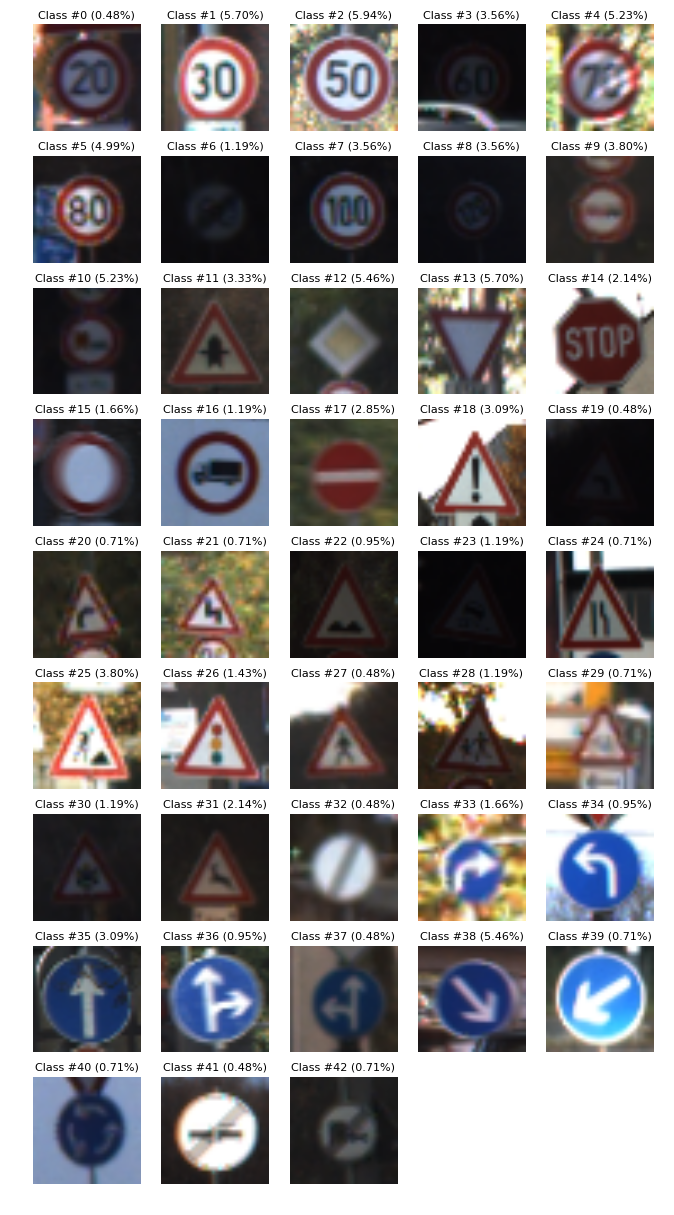

In [4]:
# Then, one of each class, to know what I'm dealing with.

y_list = list(y_test)
total = len(y_list)
fig, axarr = plt.subplots(9,5, figsize=(8, 15))
i, j = 0, 0
for label in set(y_list):
    img = X_test[y_list.index(label)]
    freq = 100. * y_list.count(label) / total
    axarr[i, j].imshow(img)
    axarr[i, j].axis("off")
    axarr[i, j].set_title("Class #%d (%.2f%%)" % (label, freq), fontsize=8)
    j += 1
    if j > 4:
        j = 0
        i += 1
axarr[8, 3].axis("off")
axarr[8, 4].axis("off")

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

# README: Proposal

I'll be trying to implement [Ciresan _et al._'s 2012 algorithm](http://people.idsia.ch/~juergen/nn2012traffic.pdf). They implemented a multi-column DNN, or "DNN committee", to achieve the [top performance in the GTSRB competition](http://benchmark.ini.rub.de/?section=gtsrb&subsection=results), with 99.46% precision. Figure 1 of the linked paper describes the approach, which in a very simplified manner is:

1. Each input is preprocessed by different methods;
2. Each preprocessed input is fed to a number of DNNs;
3. Output of all DNNs is averaged for each image.

Ciresan'12 reports that each individual DNN in the ensemble achieved precision above 98%. My personal target for this submission is 95% precision, although I'd be happy with 90% and willing to accept anything above 80% at this stage, due to time constraints related to the course timeline. Due to my humbler aspirations, a number of simplifications will be made on the original algorithm:

1. A single DNN will be used instead of an ensemble, to avoid the computational cost associated with training multiple neural nets on thousands of images;
2. Because of the above, a single preprocessing method will be used instead of three;
3. During training, the distortion step will be dropped.

These changes are documented and explained more thoroughly in the corresponding sections.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

# I. Preprocessing

In [5]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
import numpy as np
import cv2

def preprocess(image):
    # presets
    img_size = 48 # image height/width
    border = img_size // 10 # 10% borders
    new_size = img_size + (2 * border)
    new_shape = (new_size, new_size) # shape of the target image
    
    # 1. Resample image
    img_rs = np.zeros(new_shape)
    # a. If image size is new_size, do nothing:
    if image.shape == new_shape:
        img_rs = image
    # b. If image is larger, shrink using recommended downsizing interpolation
    elif image.shape > new_shape:
        img_rs = cv2.resize(src = image, dsize = new_shape, interpolation = INTER_AREA)
    # c. If image is smaller, zoom using bilinear interpolation, which is the default
    else: 
        img_rs = cv2.resize(src = image, dsize = new_shape)
    
    # 2. Crop the borders of the image
    img_48 = img_rs[border:-border,border:-border]
    
    # 3. Normalize image as per sermanet'11
    # a. Convert image to YUV space
    yuv = cv2.cvtColor(img_48, cv2.COLOR_BGR2YUV)
    # b. Normalize Y channel using adaptive histogram equalization, chosen from Ciresan'12
    clahe = cv2.createCLAHE(clipLimit = 5, tileGridSize=(6,6))
    yuv[:,:,0] = clahe.apply(yuv[:,:,0])
    norm = cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR)

    return norm

def rescale(matrix):
    # Maps an RGB image matrix from 0:255 to -1:1
    nmatrix = np.zeros_like(matrix, dtype=np.float32)
    if len(matrix.shape) == 2:
    # Greyscale:
        return (2. * matrix / 255.) - 1.
    # Colour:
    for i in range(matrix.shape[-1]):
        nmatrix[:,:,i] = (2. * matrix[:,:,i] / 255.) - 1.
    return nmatrix

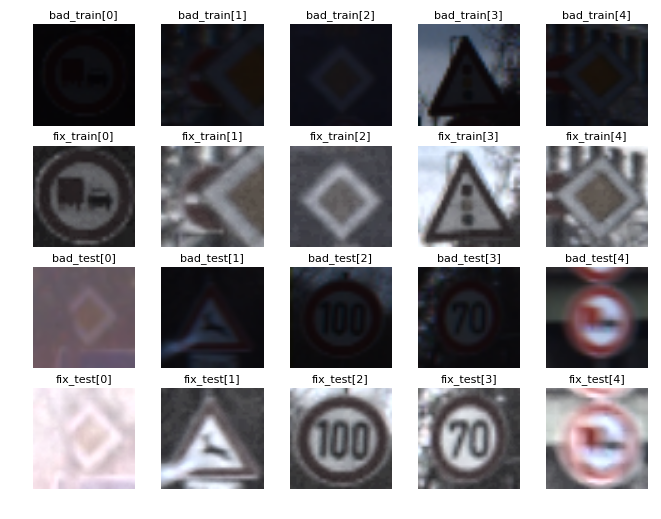

In [6]:
# Test 1: particularly bad images chosen at random by visual inspection
bad_train = [X_train[16287], X_train[24649], X_train[18641], X_train[30115], X_train[19010]]
bad_test = [X_test[1618], X_test[1339], X_test[9265], X_test[11413],X_test[3301]]

fig, axarr = plt.subplots(4,5, figsize=(8, 6))
for i in range(5):
    img_tr = bad_train[i]
    fix_tr = preprocess(img_tr)
    img_ts = bad_test[i]
    fix_ts = preprocess(img_ts)
    axarr[0, i].imshow(img_tr)
    axarr[0, i].axis("off")
    axarr[0, i].set_title("bad_train[%d]" % i, fontsize=8)
    axarr[1, i].imshow(fix_tr, cmap="Greys_r")
    axarr[1, i].axis("off")
    axarr[1, i].set_title("fix_train[%d]" % i, fontsize=8)
    axarr[2, i].imshow(img_ts)
    axarr[2, i].axis("off")
    axarr[2, i].set_title("bad_test[%d]" % i, fontsize=8)
    axarr[3, i].imshow(fix_ts, cmap="Greys_r")
    axarr[3, i].axis("off")
    axarr[3, i].set_title("fix_test[%d]" % i, fontsize=8)

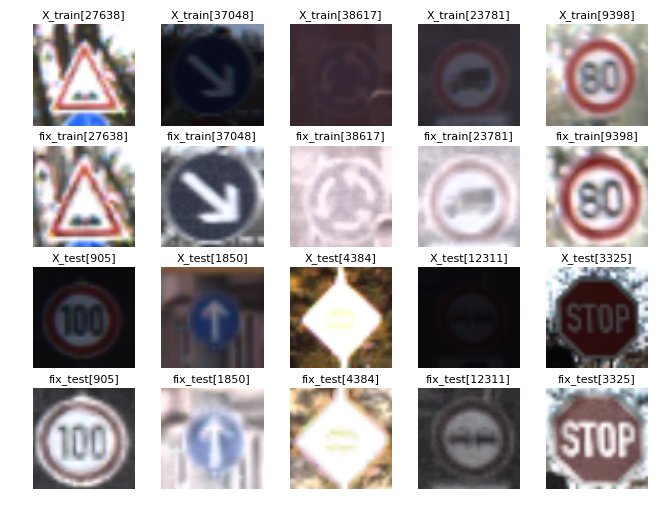

In [7]:
# Test 2: random images

fig, axarr = plt.subplots(4,5, figsize=(8, 6))
for i in range(5):
    r1 = random.randint(0, len(X_train))
    r2 = random.randint(0, len(X_test))
    img_tr = X_train[r1]
    fix_tr = preprocess(img_tr)
    img_ts = X_test[r2]
    fix_ts = preprocess(img_ts)
    axarr[0, i].imshow(img_tr)
    axarr[0, i].axis("off")
    axarr[0, i].set_title("X_train[%d]" % r1, fontsize=8)
    axarr[1, i].imshow(fix_tr, cmap="Greys_r")
    axarr[1, i].axis("off")
    axarr[1, i].set_title("fix_train[%d]" % r1, fontsize=8)
    axarr[2, i].imshow(img_ts)
    axarr[2, i].axis("off")
    axarr[2, i].set_title("X_test[%d]" % r2, fontsize=8)
    axarr[3, i].imshow(fix_ts, cmap="Greys_r")
    axarr[3, i].axis("off")
    axarr[3, i].set_title("fix_test[%d]" % r2, fontsize=8)

(0.0, 1.0, 0.0, 1.0)

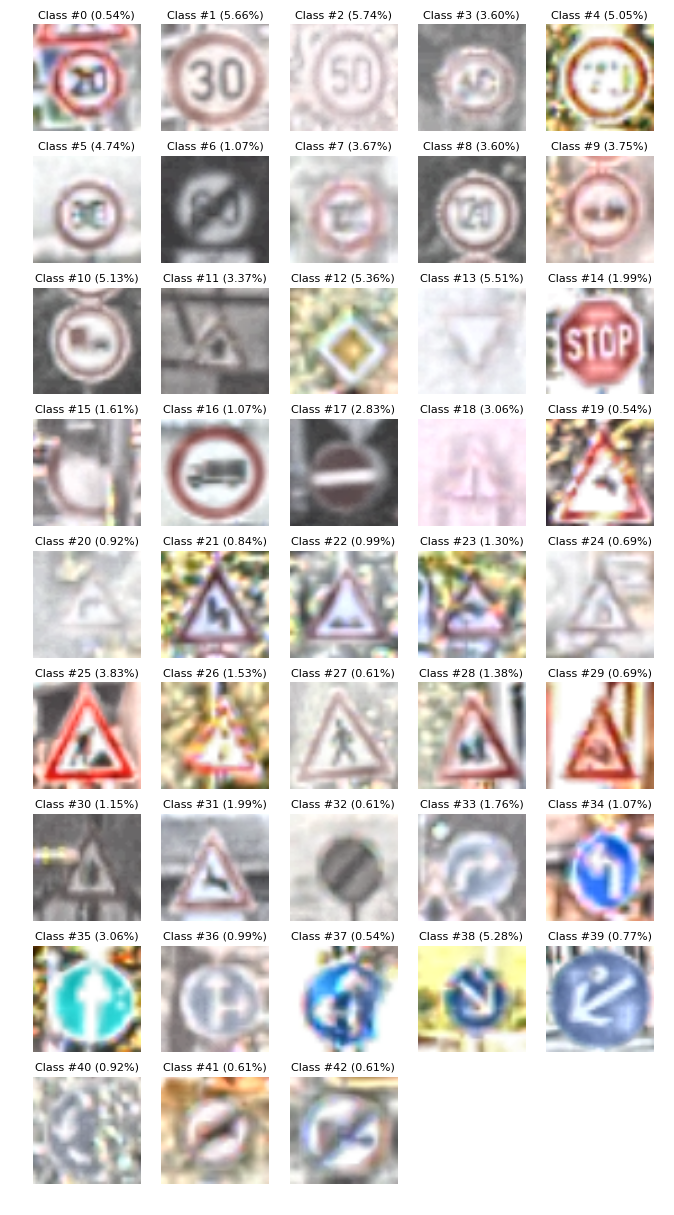

In [8]:
# Test 3: one from each class

y_list = list(y_train)
total = len(y_list)
fig, axarr = plt.subplots(9,5, figsize=(8, 15))
i, j = 0, 0
for label in set(y_list):
    img = preprocess(X_train[y_list.index(label)])
    freq = 100. * y_list.count(label) / total
    axarr[i, j].imshow(img)
    axarr[i, j].axis("off")
    axarr[i, j].set_title("Class #%d (%.2f%%)" % (label, freq), fontsize=8)
    j += 1
    if j > 4:
        j = 0
        i += 1
axarr[8, 3].axis("off")
axarr[8, 4].axis("off")

In [ ]:
# Preparing the data
X_train_prep = np.array([rescale(preprocess(img)) for img in X_train])
X_test_prep = np.array([rescale(preprocess(img)) for img in X_test])

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

Steps within the `preprocess` function:
Steps within the preprocess function:
1. Resample image to 56x56;
2. Crop 8 pixels from the borders to yield a 48 x 48 image;
3. Normalise using Contrast Limited Adaptive Histogram Equalisation, or [CLAHE](https://en.wikipedia.org/wiki/Adaptive_histogram_equalization), on the Y channel of YUV image to improve contrast. Parameters: clip limit of 1, 6x6 grid.

Algorithm chosen was Adaptive Histogram Equalization (AHE), because this method produced the most stable results in Ciresan'12. I'm not sure if the AHE used in that work was contrast limited. However, results obtained are, upon visual inspection of small samples, similar to the ones reported. 

I'm also not sure if the border trimming reported in Ciresan'12 was performed computationally, but this is the only viable method for this work. It'd be possible to attempt this method without the cropping step. The reference paper describes trimming borders of "around 10%".

The preprocessing step seemingly discarded mostly useless information, and greatly improve the visibility of very dark images, even allowing for color recognition (see test 1, case `bad_train[3]`). Quality of images with better visibility isn't terribly affected, although blue signs with decent visibility seem to suffer a bit (see test 3, classes 14 and 34 to 42).

An additional function, `rescale`, maps the image from `[0,255]` to `[-1.0,1.0]`, to improve the performance of normalization algorithms.

# II. Additional Data Generation

In [9]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

Ciresan'12 used distortions in the dataset, introduced before the start of each epoch of training, to generate randomised extra samples. This method won't be implemented in this work unless results obtained without it are below expectations.

# III. Architecture

In [29]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf

### Parameters
img_size = 48

# convolutions
stc   = [1, 1, 1, 1]     # stride used in convolution steps
conv1 = (7, 7, 3, 100)   # shape of the first convolution filter
conv2 = (4, 4, 100, 150) # shape of the second convolution filter
conv3 = (4, 4, 150, 250) # shape of the third convolution filter

# max pooling
stp  = [1, 2, 2, 1] # stride used in max pooling steps
pwnd = (1, 2, 2, 1) # shape of the max pooling windows

# fully connected layers
mult1 = (2250, 300) # fully connected layer weights shape
mult2 = (300, 43)   # output layer weights shape


### Placeholders
inputs = tf.placeholder(tf.float32, shape = (None, img_size, img_size, 3), name = 'inputs')
labels = tf.placeholder(tf.float32, shape = (None, n_classes), name = 'labels')

### Filters/Weights:
weights = {
    "conv1": tf.Variable(tf.random_normal(shape = conv1)), # convolution filter
    "conv2": tf.Variable(tf.random_normal(shape = conv2)), # convolution filter
    "conv3": tf.Variable(tf.random_normal(shape = conv3)), # convolution filter
    "mult1": tf.Variable(tf.random_normal(shape = mult1)), # fully connected layer weights
    "mult2": tf.Variable(tf.random_normal(shape = mult2))  # output layer weights
          }
### Biases
biases = {
    "conv1": tf.Variable(tf.random_normal(shape = conv1[-1:])),
    "conv2": tf.Variable(tf.random_normal(shape = conv2[-1:])),
    "conv3": tf.Variable(tf.random_normal(shape = conv3[-1:])),
    "mult1": tf.Variable(tf.random_normal(shape = mult1[-1:])),
    "mult2": tf.Variable(tf.random_normal(shape = mult2[-1:]))
         }

### Operations:
# first convolution
layer1 = tf.nn.conv2d(input = inputs, filter = weights["conv1"],
                      strides = stc, padding = "VALID")
layer1 = tf.add(layer1, biases["conv1"])

# first max pooling
layer2 = tf.nn.max_pool(value = layer1, ksize = pwnd,
                        strides = stp, padding = "VALID")
layer2 = tf.tanh(layer2)

# second convolution
layer3 = tf.nn.conv2d(input = layer2, filter = weights["conv2"],
                      strides = stc, padding = "VALID")
layer3 = tf.add(layer3, biases["conv2"])

# second max pooling
layer4 = tf.nn.max_pool(value = layer3, ksize = pwnd,
                        strides = stp, padding = "VALID")
layer4 = tf.tanh(layer4)

# third convolution
layer5 = tf.nn.conv2d(input = layer4, filter = weights["conv3"],
                      strides = stc, padding = "VALID")
layer5 = tf.add(layer5, biases["conv3"])

# third max pooling
layer6 = tf.nn.max_pool(value = layer5, ksize = pwnd,
                        strides = stp, padding = "VALID")
layer5 = tf.tanh(layer5)

# fully connected layer
layer7 = tf.matmul(tf.reshape(layer6, [-1, 2250]), weights["mult1"])
layer7 = tf.tanh(tf.add(layer7, biases["mult1"]))

# output layer
output = tf.matmul(layer7, weights["mult2"])
output = tf.nn.softmax(tf.add(output, biases["mult2"]))

print("Architecture built successfully!")

Architecture built successfully!


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

Same architecture will be used here as in Ciresan'12. These are the layers used:

0. Input → 48×48 neurons with 3 maps (RGB image regularised to [-1,1])
1. Convolution (7×7 filter) → 42×42 neurons with 100 maps
2. Max-pooling (2×2 window) → 21×21 neurons with 100 maps
3. Convolution (4×4 filter) → 18×18 neurons with 150 maps
4. Max-pooling (2×2 window) → 9×9 neurons with 150 maps
5. Convolution (4×4 filter) → 6×6 neurons with 250 maps
6. Max-pooling (2×2 window) → 3×3 neurons with 250 maps
7. Fully connected → 300 neurons
8. Output → 43 neurons

Activation function is a hyperbolic function in the fully connected and max-pooling layers. The output layer uses a softmax function. A bias is added to each convolution and fully connected layer. All convolution layers use a stride  of one, while max-pooling layers use a stride of two. Valid padding is used whenever applicable.

Training time reported in the paper was 37h for an ensemble of 25 DNNS, using a machine with 3.3GHz, 24GB DDR3 and four GTX580 GPUs. I'm using one with 2.7GHz, 16GB DDR3 and one GT650 GPU. It's hard to accurately estimate, but I'm hoping a single DNN with this configuration will be successfully trained overnight.

# IV. Training

In [27]:
### Train your model here.
### Feel free to use as many code cells as needed.


### TrainingSetup

# Parameters:
learning_rate = 0.5
training_epochs = 1
batch_size = 500

# Optimization
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(output, labels))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

### Repeating the basic data summary for the preprocessed data.

n_train = X_train_prep.shape
n_test = X_test_prep.shape
image_shape = X_train_prep[0].shape

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)

Number of training examples = (39209, 48, 48, 3)
Number of testing examples = (12630, 48, 48, 3)
Image data shape = (48, 48, 3)


In [28]:
### Training
# Initializing the variables
init = tf.initialize_all_variables()

# Launch the graph
with tf.Session() as session:
    session.run(init)
    # Training cycle
    for _ in range(training_epochs):
        for i in range(0, n_train, batch_size):
            batch_x = X_train_prep[i : i + batch_size]
            batch_y = y_train[i : i + batch_size]
            # Run optimization op (backprop) and cost op (to get loss value)
            # session.run(optimizer, feed_dict={inputs: batch_x, labels: batch_y})
            print(batch_x.shape)
            print(batch_y.shape)

InvalidArgumentError: shape must be a vector of {int32,int64}, got shape []
	 [[Node: random_normal_52/RandomStandardNormal = RandomStandardNormal[T=DT_INT32, dtype=DT_FLOAT, seed=0, seed2=0, _device="/job:localhost/replica:0/task:0/cpu:0"](random_normal_52/shape)]]
Caused by op 'random_normal_52/RandomStandardNormal', defined at:
  File "/Users/kadu/anaconda/envs/carnd/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/kadu/anaconda/envs/carnd/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/kadu/anaconda/envs/carnd/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/kadu/anaconda/envs/carnd/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/kadu/anaconda/envs/carnd/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/Users/kadu/anaconda/envs/carnd/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/Users/kadu/anaconda/envs/carnd/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Users/kadu/anaconda/envs/carnd/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/kadu/anaconda/envs/carnd/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/kadu/anaconda/envs/carnd/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/kadu/anaconda/envs/carnd/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/kadu/anaconda/envs/carnd/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/kadu/anaconda/envs/carnd/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/kadu/anaconda/envs/carnd/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/kadu/anaconda/envs/carnd/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Users/kadu/anaconda/envs/carnd/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/kadu/anaconda/envs/carnd/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/kadu/anaconda/envs/carnd/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/kadu/anaconda/envs/carnd/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/kadu/anaconda/envs/carnd/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-26-386e6fcaa07b>", line 41, in <module>
    "mult2": tf.Variable(tf.random_normal(shape = mult2[-1]))
  File "/Users/kadu/anaconda/envs/carnd/lib/python3.5/site-packages/tensorflow/python/ops/random_ops.py", line 81, in random_normal
    seed2=seed2)
  File "/Users/kadu/anaconda/envs/carnd/lib/python3.5/site-packages/tensorflow/python/ops/gen_random_ops.py", line 187, in _random_standard_normal
    name=name)
  File "/Users/kadu/anaconda/envs/carnd/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 703, in apply_op
    op_def=op_def)
  File "/Users/kadu/anaconda/envs/carnd/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2317, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/kadu/anaconda/envs/carnd/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1239, in __init__
    self._traceback = _extract_stack()


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

I didn't have much prior experience with DNNs, and if I were to implement from scratch, I'd either "come up" with what I had seen in class (_i.e._ use the same everything) or waste time pursuing counterproductive approaches.

Therefore, I did what I know how to: I researched the literature on this exact problem, took a brief look at [a](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) [few](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/DeepConvexNetwork-Interspeech2011-pub.pdf) [approaches](http://yann.lecun.com/exdb/publis/pdf/ranzato-06.pdf)\* and chose [Ciresan _et al._, 2012](http://people.idsia.ch/~juergen/nn2012traffic.pdf), because:

1. It was designed for this specific purpose, and had top performance in the competition;
2. At a brief look, the method seemed wellvery well explained in the paper, so reimplementing it should be straightforward even for someone with little `tensorflow` experience;
3. The algorithm described showed several opportunities for simplification;
4. There was sufficient reason to believe that even the simplified version of the algorithm would perform decently, due to a number of tests also reported in the paper.

<sub>\* Two things worth noting here. First: I didn't read all of those texts in their entirety, a brief look at the layout and equations presented allows to tell which ones would be easier to implement, namely the one I used and the one cited in the instructions of this notebook. 

<sub>Second: some of those are on digit recognition, but it's a similar enough task. If I were to implement any of them, I'd just have added to the preprocessing task a pre-classifier based on colour and/or shape (to divide the 43 classes into a smaller amount) and a binariser, to try and extract the symbol in the centre. I'm not sure how hard this would've been to achieve, and it seems like an interesting endeavour.

<sub>However, given that I'm taking this course to learn new things, I decided to go for the deep/conv net approach. The alternative method is just an image manipulation task followed by a classifier similar to the one used in the not-MNIST lab, and I already know those things better than I know DNNs.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [3]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [4]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.